# Prepare

In [1]:
# These are my default settings
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# import joblib

plt.rcParams["figure.figsize"] = (12, 6)
sns.set()
pd.set_option("display.max_columns", None)

# Preparation test data

In [2]:
image_height = 150
image_width = 150

data = "../alien_vs_predator_ep2/Data"
test_dir = f"{data}/Test"

from tensorflow.keras.utils import image_dataset_from_directory as get_img

test_data = get_img(
    test_dir,
    image_size=(image_width, image_height),
    batch_size=200
)

for X_test, y_test in test_data.take(1):
    print(type(X_test), X_test.shape, "\n", type(y_test), y_test.shape)

Found 200 files belonging to 2 classes.
<class 'tensorflow.python.framework.ops.EagerTensor'> (200, 150, 150, 3) 
 <class 'tensorflow.python.framework.ops.EagerTensor'> (200,)


In [3]:
# casiting

X_test_np = X_test.numpy().astype("float32")
y_test_np = y_test.numpy()

print(type(X_test_np), type(y_test_np))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


# predict

In [4]:
# call vgg16 to predict X_test
from tensorflow.keras import models

vgg16 = models.load_model("vgg16_ep3")
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [5]:
# check abalability of gpu.  if  '/device:GPU:0', gpu is abalable
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
from tensorflow.keras.applications.vgg16 import preprocess_input

In [7]:
y_pred = vgg16.predict(
    preprocess_input(X_test_np)
)

7/7 [==============================] - 7s 60ms/step


In [8]:
X_test_reshaped = np.reshape(y_pred, (200, 4*4*512))
X_test_reshaped.shape

(200, 8192)

In [9]:
# call saved model

model = models.load_model("model_ep3")

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


In [10]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

test_pred = model.predict(X_test_reshaped)

7/7 [==============================] - 0s 4ms/step


In [11]:
cr = classification_report(y_true=y_test_np, y_pred=test_pred>0.75)
print(cr)

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       100
           1       0.88      0.92      0.90       100

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.90      0.90       200



(array([0.5, 1.5]), [Text(0, 0.5, 'Alien'), Text(0, 1.5, 'Predator')])

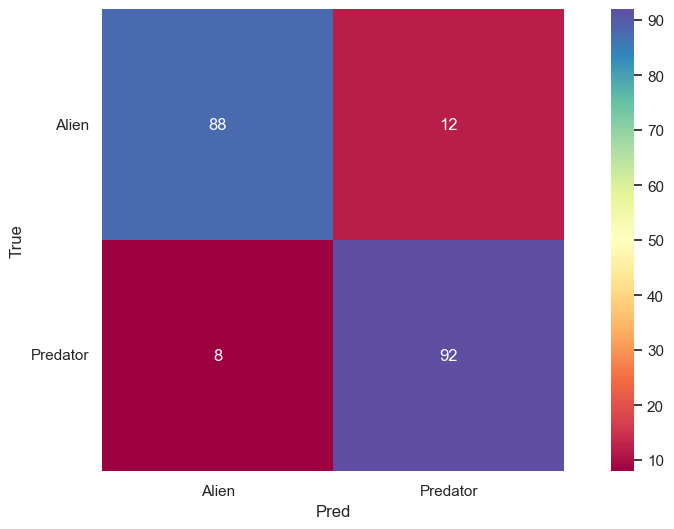

In [12]:
cm = confusion_matrix(y_true=y_test_np, y_pred=test_pred>0.75)

cm = pd.DataFrame(data=cm, index=["Alien", "Predator"], 
                           columns=["Alien", "Predator"])

sns.heatmap(cm, square=True, annot=True, cmap="Spectral")
plt.xlabel("Pred")
plt.ylabel("True")
plt.yticks(rotation=0)


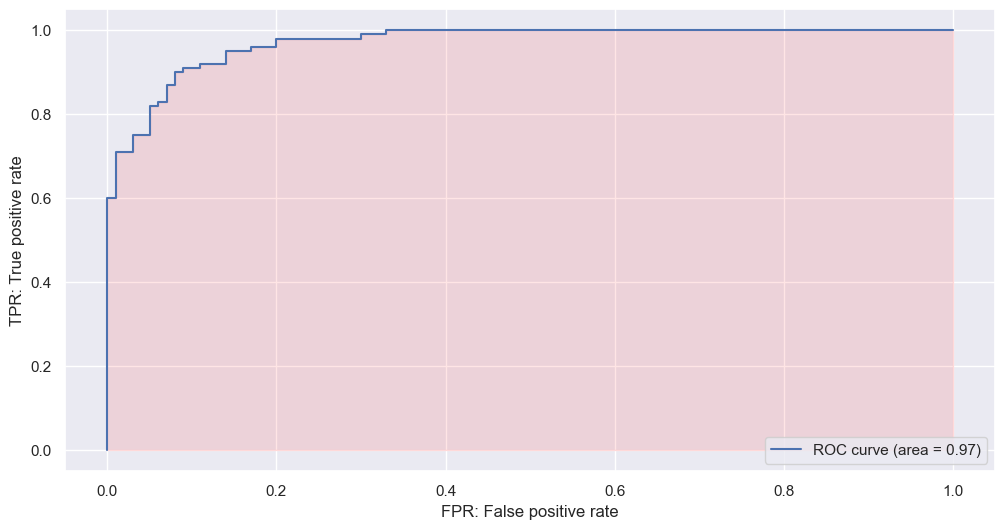

In [13]:
fpr, tpr, thresholds = roc_curve(y_test_np, test_pred)
auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.fill_between(fpr, tpr, 0, color="red", alpha=0.1)
plt.legend()
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
# plt.grid()
plt.show()